### Imports


In [164]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


### Data Exploration

In [ ]:

# Reload the CSV file
file_path = "assignTTSWING.csv"
df = pd.read_csv(file_path)


In [ ]:
# Filter only feature columns (exclude metadata and IDs)
feature_columns = [col for col in df.columns if col.startswith(('a_', 'g_', 'ax_', 'ay_', 'az_', 'gx_', 'gy_', 'gz_'))]
features = df[feature_columns]

# Assign the labels
testmode_labels = df['testmode'] if 'testmode' in df.columns else None
gender_labels = df['gender'] if 'gender' in df.columns else None
age_labels = df['age'] if 'age' in df.columns else None
playYears_labels = df['playYears'] if 'playYears' in df.columns else None
height_labels = df['height'] if 'height' in df.columns else None
weight_labels = df['weight'] if 'weight' in df.columns else None
handedness_labels = df['handedness'] if 'handedness' in df.columns else None
holdRacketHanded_labels = df['holdRacketHanded'] if 'holdRacketHanded' in df.columns else None

# Combine all labels into a single DataFrame
labels_df = pd.DataFrame({
    'testmode': testmode_labels,
    'gender' : gender_labels,
    'age' : age_labels,
    'playYears' : playYears_labels,
    'height' : height_labels,
    'weight' : weight_labels,
    'handedness' : handedness_labels,
    'holdRacketHanded' : holdRacketHanded_labels
})


In [ ]:
# Convert all labels to string type
labels_df = labels_df.astype(str)

In [ ]:
# Count how many of each label we have
label_counts = labels_df.apply(pd.Series.value_counts).fillna(0).astype(int)

# Print the label counts
print("Label counts:")
print(label_counts)

In [ ]:
# Reveal the rows that are ??? for age, playYears, height, weight
missing_labels = labels_df[labels_df.isin(['???']).any(axis=1)]

# Print the rows with missing labels
print("\nRows with missing labels:")
print(missing_labels)

# Create a list of all the rows that are ??? for age, playYears, height, weight
missing_rows = missing_labels.index.tolist()

# Delete the rows with missing labels from the labels and features DataFrames
labels_df = labels_df.drop(missing_rows)
features = features.drop(missing_rows)

In [176]:
# Recheck that the invalid rows are gone
# Count how many of each label we have
label_counts = labels_df.apply(pd.Series.value_counts)

# Print the label counts
print("Label counts:")
print(label_counts)

Label counts:
        testmode   gender      age  playYears   height   weight  handedness  \
0         7500.0  38550.0      NaN        NaN      NaN      NaN     16100.0   
1        73850.0  58800.0      NaN        NaN      NaN      NaN     81250.0   
2        16000.0      NaN      NaN        NaN      NaN      NaN         NaN   
high         NaN      NaN  18150.0    23200.0  29100.0  29250.0         NaN   
low          NaN      NaN  26900.0    21250.0  27450.0  31500.0         NaN   
medium       NaN      NaN  52300.0    52900.0  40800.0  36600.0         NaN   

        holdRacketHanded  
0                16100.0  
1                81250.0  
2                    NaN  
high                 NaN  
low                  NaN  
medium               NaN  


### PCA

In [ ]:
# Compute the PCA via the covariance matrix method

# Standardize the features
mean = features.mean()
std = features.std()
features_standardized = (features - mean) / std

# Compute the covariance matrix
cov_matrix = features_standardized.cov()

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Perform dimensionality reduction by multiplying the data by the top two eigenvectors
pca_features = np.dot(features_standardized, sorted_eigenvectors[:, :2])
pca_features_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_features_df, x='PC1', y='PC2', hue=testmode_labels, palette='Set1', alpha=0.7)
plt.title('PCA of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Test Mode')
plt.grid()
plt.savefig('pca_features.png')
plt.show()



In [ ]:

# Again but with feature changed into ndarray
features_np = features.values

# Standardize the features
mean = np.mean(features_np, axis=0)
std_dev = np.std(features_np, axis=0)
features_standardized_np = (features_np - mean) / std_dev

# Compute the covariance matrix
cov_matrix_np = np.cov(features_standardized_np.T)

# Compute the eigenvalues and eigenvectors
eigenvalues_np, eigenvectors_np = np.linalg.eig(cov_matrix_np)
sorted_indices = np.argsort(eigenvalues_np)[::-1]
eigenvalues = eigenvalues_np[sorted_indices]
eigenvectors = eigenvectors_np[:, sorted_indices]

# Perform dimensionality reduction by multiplying the data by the top two eigenvectors
reduced_features = np.dot(features_standardized_np, eigenvectors[:, :2])



In [ ]:
# Make a Scree graph for all eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot of Eigenvalues')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid()
plt.savefig('scree_plot.png')
plt.show()

# Make another Scree graph for all eigenvalues but the y-axis is the percentage of variance explained
plt.figure(figsize=(10, 6))
explained_variance = eigenvalues / np.sum(eigenvalues) * 100
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot of Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Make a cumulative explained variance plot
plt.figure(figsize=(10, 6))
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance (%)')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid()
plt.show()

# Check that the percentages add up to 100%
total_variance = np.sum(explained_variance)
print(f"Total variance explained by all components: {total_variance:.2f}%")


In [ ]:
# Reduce the features to 16 dimensions using PCA
reduced_features_16 = np.dot(features_standardized_np, eigenvectors[:, :16])

# Plot the correlation matrix of the reduced 16D features
plt.figure(figsize=(12, 10))
sns.heatmap(np.corrcoef(reduced_features_16.T), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Reduced 16D Features')
plt.show()


In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


### K-NN ALGORITHM

#### K-NN WITH ORIGINAL DATASET

In [182]:
def run_knn_from_split(X_train, X_test, y_train, y_test, n_neighbors=5, class_names=None, plot_confusion=False, verbose=False, label_name=""):
    # Fit KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Accuracy and loss
    accuracy = accuracy_score(y_test, y_pred)
    loss = 1 - accuracy

    if verbose:
        print(f"\nK-NN Results for label: {label_name}")
        print(classification_report(y_test, y_pred, target_names=class_names))
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Loss: {loss:.4f}")

    if plot_confusion:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix: {label_name}')
        plt.tight_layout()
        plt.show()

    return accuracy, loss, knn

# Example usage:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_of_interest = 'height'
y = labels_df[label_of_interest].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Split once
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Run KNN for k=1
accuracy, loss, _ = run_knn_from_split(X_train, X_test, y_train, y_test, n_neighbors=1, class_names=class_names, label_name=label_of_interest)


n_neighbors=1: accuracy=0.8768, loss=0.1232
n_neighbors=2: accuracy=0.8591, loss=0.1409
n_neighbors=4: accuracy=0.8744, loss=0.1256
n_neighbors=8: accuracy=0.8694, loss=0.1306
n_neighbors=16: accuracy=0.8585, loss=0.1415
n_neighbors=32: accuracy=0.8391, loss=0.1609
n_neighbors=64: accuracy=0.8097, loss=0.1903
n_neighbors=128: accuracy=0.7653, loss=0.2347
n_neighbors=256: accuracy=0.7117, loss=0.2883
n_neighbors=512: accuracy=0.6525, loss=0.3475
n_neighbors=1024: accuracy=0.5874, loss=0.4126
n_neighbors=2048: accuracy=0.5543, loss=0.4457
n_neighbors=4096: accuracy=0.5289, loss=0.4711


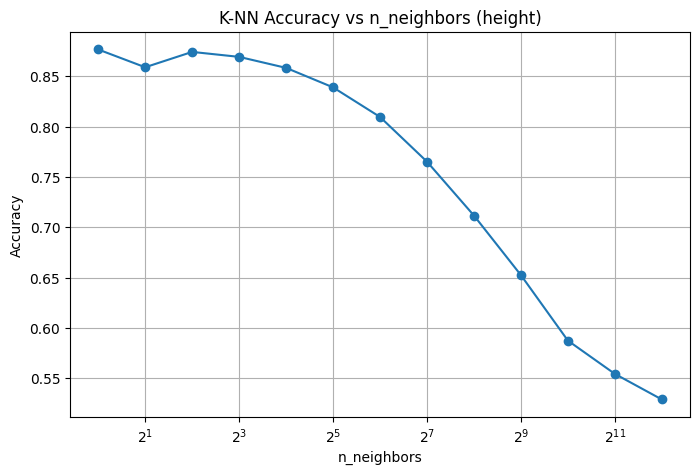

In [183]:
n_neighbors_list = [2**i for i in range(13)]  # 1, 2, 4, ..., 4096
results = []

label_of_interest = 'height'  # any label you want

for n in n_neighbors_list:
    try:
        accuracy, loss, knn = run_knn_from_split(X_train, X_test, y_train, y_test, n_neighbors=n, class_names=class_names, label_name=label_of_interest)
        results.append({'n_neighbors': n, 'accuracy': accuracy, 'loss': loss, 'knn_model': knn})
        print(f"n_neighbors={n}: accuracy={accuracy:.4f}, loss={loss:.4f}")
    except ValueError as e:
        print(f"n_neighbors={n}: Error - {e}")

# Optionally, plot accuracy vs n_neighbors
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot([r['n_neighbors'] for r in results], [r['accuracy'] for r in results], marker='o')
plt.xscale('log', base=2)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title(f'K-NN Accuracy vs n_neighbors ({label_of_interest})')
plt.grid(True)
plt.show()

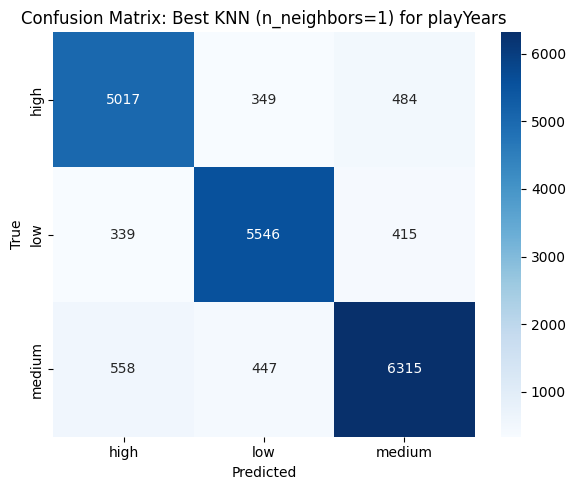

In [178]:
# Find the best KNN model (highest accuracy)
best_result = max(results, key=lambda x: x['accuracy'])
best_knn = best_result['knn_model']
best_n = best_result['n_neighbors']

# Predict on the test set using the best model
y_pred_best = best_knn.predict(X_test)

# Plot confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: Best KNN (n_neighbors={best_n}) for {label_of_interest}')
plt.tight_layout()
plt.show()

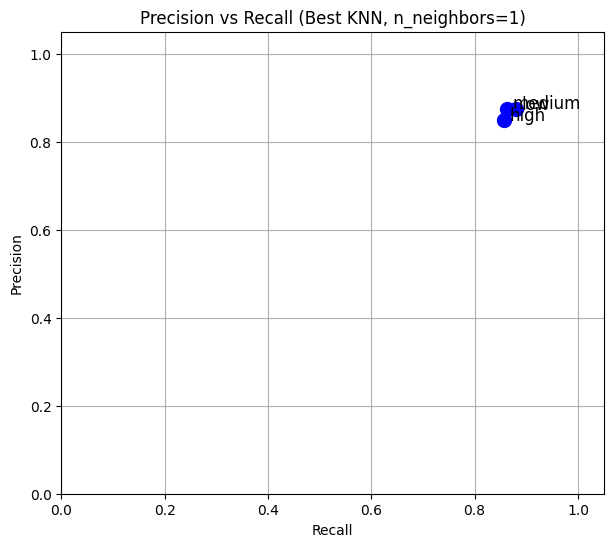

In [179]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision and recall for each class
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_best, zero_division=0)

plt.figure(figsize=(7, 6))
plt.scatter(recall, precision, s=100, c='b')
for i, class_name in enumerate(class_names):
    plt.text(recall[i]+0.01, precision[i], class_name, fontsize=12)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision vs Recall (Best KNN, n_neighbors={best_n})')
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

#### K-NN WITH PCA DATASET

### K-MEANS ALGORITHM

In [ ]:
# # Run k-means with a guessed number of clusters (e.g., 3)
# k = 3
# kmeans = KMeans(n_clusters=k, random_state=42)
# cluster_labels = kmeans.fit_predict(X_scaled)

# # Evaluate clustering with silhouette score
# sil_score = silhouette_score(X_scaled, cluster_labels)

# # Prepare dataframe for plotting
# pca_df = pd.DataFrame({
#     'PC1': X_pca[:, 0],
#     'PC2': X_pca[:, 1],
#     'Cluster': cluster_labels
# })

# # Plot PCA-reduced features colored by cluster
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
# plt.title(f'K-Means Clustering (k={k}) on PCA-Reduced Features\nSilhouette Score = {sil_score:.2f}')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Cluster')
# plt.tight_layout()
# plt.show()

In [ ]:
# Perform k-Means clustering on the original features
# Encode weight labels as integers for evaluation
from sklearn.preprocessing import LabelEncoder
current_label_of_interest = 'handedness'
cluster_numbers = 2
weight_encoded = LabelEncoder().fit_transform(labels_df[current_label_of_interest])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Choose k=3 for the three weight categories
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=1)
cluster_labels = kmeans.fit_predict(X_scaled)

# Compare clusters to actual weight catWegories
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix (clusters vs. true weight categories):")
print(confusion_matrix(weight_encoded, cluster_labels))

print("\nClassification Report (clusters vs. true weight categories):")
print(classification_report(weight_encoded, cluster_labels, target_names=LabelEncoder().fit(labels_df[current_label_of_interest]).classes_))


In [ ]:
# Plot the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(weight_encoded, cluster_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(cm.shape[1])],
            yticklabels=weight_classes)
plt.xlabel('KMeans Cluster')
plt.ylabel('True Category')
plt.title('Confusion Matrix: KMeans Clusters vs. True Weight Categories')
plt.tight_layout()
plt.show()

In [ ]:
# Perform k-Means clustering on the top 16D PCA-reduced features
# Encode weight labels as integers for evaluation
from sklearn.preprocessing import LabelEncoder
weight_encoded = LabelEncoder().fit_transform(labels_df[current_label_of_interest])

# Run KMeans on the 16D PCA-reduced features
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features_16)

# Compare clusters to actual weight categories
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix (clusters vs. true categories):")
print(confusion_matrix(weight_encoded, cluster_labels))

print("\nClassification Report (clusters vs. true categories):")
print(classification_report(weight_encoded, cluster_labels, target_names=LabelEncoder().fit(labels_df[current_label_of_interest]).classes_))


In [ ]:
# Plot the confusion matrix for the 16D PCA-reduced features
# Compute the confusion matrix
cm = confusion_matrix(weight_encoded, cluster_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(cm.shape[1])],
            yticklabels=weight_classes)
plt.xlabel('KMeans Cluster')
plt.ylabel('True Weight Category')
plt.title('Confusion Matrix: KMeans Clusters vs. True Weight Categories')
plt.tight_layout()
plt.show()

In [ ]:
# Perform k-Means clustering on the top 2D PCA-reduced features
# Encode weight labels as integers for evaluation
from sklearn.preprocessing import LabelEncoder
weight_encoded = LabelEncoder().fit_transform(labels_df[current_label_of_interest])

# Run KMeans on the 16D PCA-reduced features
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

# Compare clusters to actual weight categories
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix (clusters vs. true weight categories):")
print(confusion_matrix(weight_encoded, cluster_labels))

print("\nClassification Report (clusters vs. true weight categories):")
print(classification_report(weight_encoded, cluster_labels, target_names=LabelEncoder().fit(labels_df[current_label_of_interest]).classes_))


In [ ]:
# Plot the confusion matrix for the 2D PCA-reduced features
# Compute the confusion matrix
cm = confusion_matrix(weight_encoded, cluster_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(cm.shape[1])],
            yticklabels=weight_classes)
plt.xlabel('KMeans Cluster')
plt.ylabel('True Weight Category')
plt.title('Confusion Matrix: KMeans Clusters vs. True Weight Categories')
plt.tight_layout()
plt.show()

In [ ]:
# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Run KMeans clustering (k=3 for weight categories)
k = cluster_numbers
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Get cluster centers in PCA space
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Define the color palette and cluster count
palette = sns.color_palette('Set2', n_colors=k)

# Plot all clusters together and get axis limits
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette=palette, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('KMeans Clusters in PCA-Reduced Space (All Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
# Get axis limits
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.show()

# Plot each cluster separately with matching color and same axis limits
for cluster_id in range(k):
    plt.figure(figsize=(8, 6))
    mask = (cluster_labels == cluster_id)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=palette[cluster_id], alpha=0.7, label=f'Cluster {cluster_id}')
    plt.scatter(centroids_pca[cluster_id, 0], centroids_pca[cluster_id, 1], s=200, c='red', marker='X', label='Centroid')
    plt.title(f'KMeans Cluster {cluster_id} in PCA-Reduced Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Encode weight categories as integers for coloring
weight_labels = labels_df[current_label_of_interest].values
weight_encoded = LabelEncoder().fit_transform(weight_labels)
weight_classes = LabelEncoder().fit(labels_df[current_label_of_interest]).classes_
palette_weights = sns.color_palette('Set2', n_colors=len(weight_classes))

# Plot all weight categories together using the same axis limits as before
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=weight_labels, palette=palette_weights, alpha=0.7)
plt.title('True Weight Categories in PCA-Reduced Space (All Samples)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Weight Category')
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.show()

# Plot each weight category separately with matching color and same axis limits
for idx, weight_class in enumerate(weight_classes):
    plt.figure(figsize=(8, 6))
    mask = (weight_labels == weight_class)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=palette_weights[idx], alpha=0.7, label=f'Weight: {weight_class}')
    plt.title(f'Category: {weight_class} in PCA-Reduced Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()